## Last homework

This week we will apply techniques learned during the semester as a recap of the learned methods. We will use a dataset from the paper "Hurricane-induced selection on the morphology of an island lizard", where body parameters of lizards are measured on an island before and after the hurricane. We will make binary predictions if a lizard was measured before of after the hurricane in the upcoming tasks.

When a task is not fully described, try to come up with a reasonable solution!

Data source: https://www.nature.com/articles/s41586-018-0352-3#Sec7

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
from tabulate import tabulate

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.gridspec as gridspec

from IPython.display import display

In [3]:
from hw_utils import *

In [4]:
import sklearn
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

In [5]:
data = './data/'
out = './out/'

# Bold print for Jupyter Notebook
b1 = '\033[1m'
b0 = '\033[0m'

### Just some matplotlib and seaborn parameter tuning

In [6]:
axistitlesize = 20
axisticksize = 17
axislabelsize = 26
axislegendsize = 23
axistextsize = 20
axiscbarfontsize = 15

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colorpalettes, colormaps, etc.
sns.set_palette(palette='rocket')
rocket_cmap = sns.color_palette('rocket', as_cmap=True)

target_colors = np.array([cm.magma(0.5), cm.magma(0.75), cm.magma(0.93)])
feature_colors = np.array([rocket_cmap(0.17), cm.magma(0.45), cm.magma(0.60), cm.magma(0.75)])

## 1. Load & prepare data
 - load the provided dataset
 - look for missing values, handle them! Be careful! (You can screw up the whole assignment here)
 - We will make binary predictions if a lizard was before of after the hurricane in the upcoming tasks. 
 - Convert all the features to numeric or binary features.
 - get rid of the ID column

### 1./a. Load and explore data

In [7]:
f = os.listdir(data)[0]
df = pd.read_csv(data + f)

In [8]:
display(df.head())
display(df.tail())

,ID,Hurricane,Origin,Sex,SVL,Femur,Tibia,Metatarsal,LongestToe,Humerus,...,FingerArea2,FingerArea3,ToeArea1,ToeArea2,ToeArea3,MeanFingerArea,MeanToeArea,SumFingers,SumToes,MaxFingerForce
0,537,After,Pine Cay,Male,48.69,10.39,11.87,7.52,7.43,8.66,...,1.338,1.339,2.529,2.402,2.369,1.332667,2.433333,2.663,4.791,0.116
1,539,After,Pine Cay,Female,40.31,8.66,9.79,6.18,6.20,8.01,...,0.950,0.972,1.498,1.525,1.530,0.961333,1.517667,2.595,3.678,0.048
2,540,After,Pine Cay,Male,58.30,12.87,14.76,9.45,9.58,11.72,...,2.702,2.685,4.157,4.140,3.996,2.631333,4.097667,7.347,4.682,0.424
3,541,After,Pine Cay,Female,43.15,8.55,10.29,6.60,6.26,7.43,...,1.175,1.186,1.898,1.871,1.867,1.177667,1.878667,2.786,5.378,0.171
4,542,After,Pine Cay,Female,45.51,10.26,11.02,6.89,7.02,7.71,...,1.357,1.420,2.627,2.435,2.529,1.384333,2.530333,3.575,6.646,0.014


,ID,Hurricane,Origin,Sex,SVL,Femur,Tibia,Metatarsal,LongestToe,Humerus,...,FingerArea2,FingerArea3,ToeArea1,ToeArea2,ToeArea3,MeanFingerArea,MeanToeArea,SumFingers,SumToes,MaxFingerForce
159,WC66,Before,Water Cay,Female,43.04,9.23,9.96,6.29,5.72,7.12,...,1.008,1.031,1.170,1.127,1.148,1.018000,1.148333,NaN,NaN,NaN
160,WC69,Before,Water Cay,Female,42.38,9.21,9.80,6.68,6.29,7.38,...,0.920,0.894,1.542,1.526,1.527,0.908667,1.531667,NaN,NaN,NaN
161,WC70,Before,Water Cay,Female,45.74,9.79,10.08,6.61,6.54,8.05,...,1.119,1.146,1.719,1.716,1.703,1.133667,1.712667,NaN,NaN,NaN
162,WC71,Before,Water Cay,Female,40.95,9.04,10.08,6.26,5.52,7.27,...,0.793,0.777,1.227,1.234,1.252,0.784000,1.237667,NaN,NaN,NaN
163,WC72,Before,Water Cay,Female,40.62,8.64,9.77,6.14,6.61,6.91,...,0.842,0.845,1.122,1.203,1.116,0.838000,1.147000,NaN,NaN,NaN


#### Select binary and non-binary columns

In [9]:
# Cut off the ID and Origin column
columns = df.columns.delete([0,2])

# Column types:
# Binary columns     : columns[:2]
# Non-binary columns : columns[2:]

#### Convert binary columns from string values to ints

In [10]:
# Copy original DataFrame to keep it intact
df_n = df.copy()

In [11]:
# Create a map for binary values and apply it on the copied DataFrame
map_hurricane = {'Before' : 0, 'After' : 1}
map_sex = {'Female' : 0, 'Male' : 1}

df_n['Hurricane'] = df['Hurricane'].map(map_hurricane)
df_n['Sex'] = df['Sex'].map(map_sex)

In [12]:
hist = {}
bins = {}
width = {}
center = {}
for c in columns[2:]:
    hist[c], bins[c] = np.histogram(df_n[c][~df_n[c].isna()], bins=10, density=True)
    width[c] = 0.8 * (bins[c][1] - bins[c][0])
    center[c] = (bins[c][:-1] + bins[c][1:]) / 2

#### Inspect distribution of non-binary values before and after the hurricane

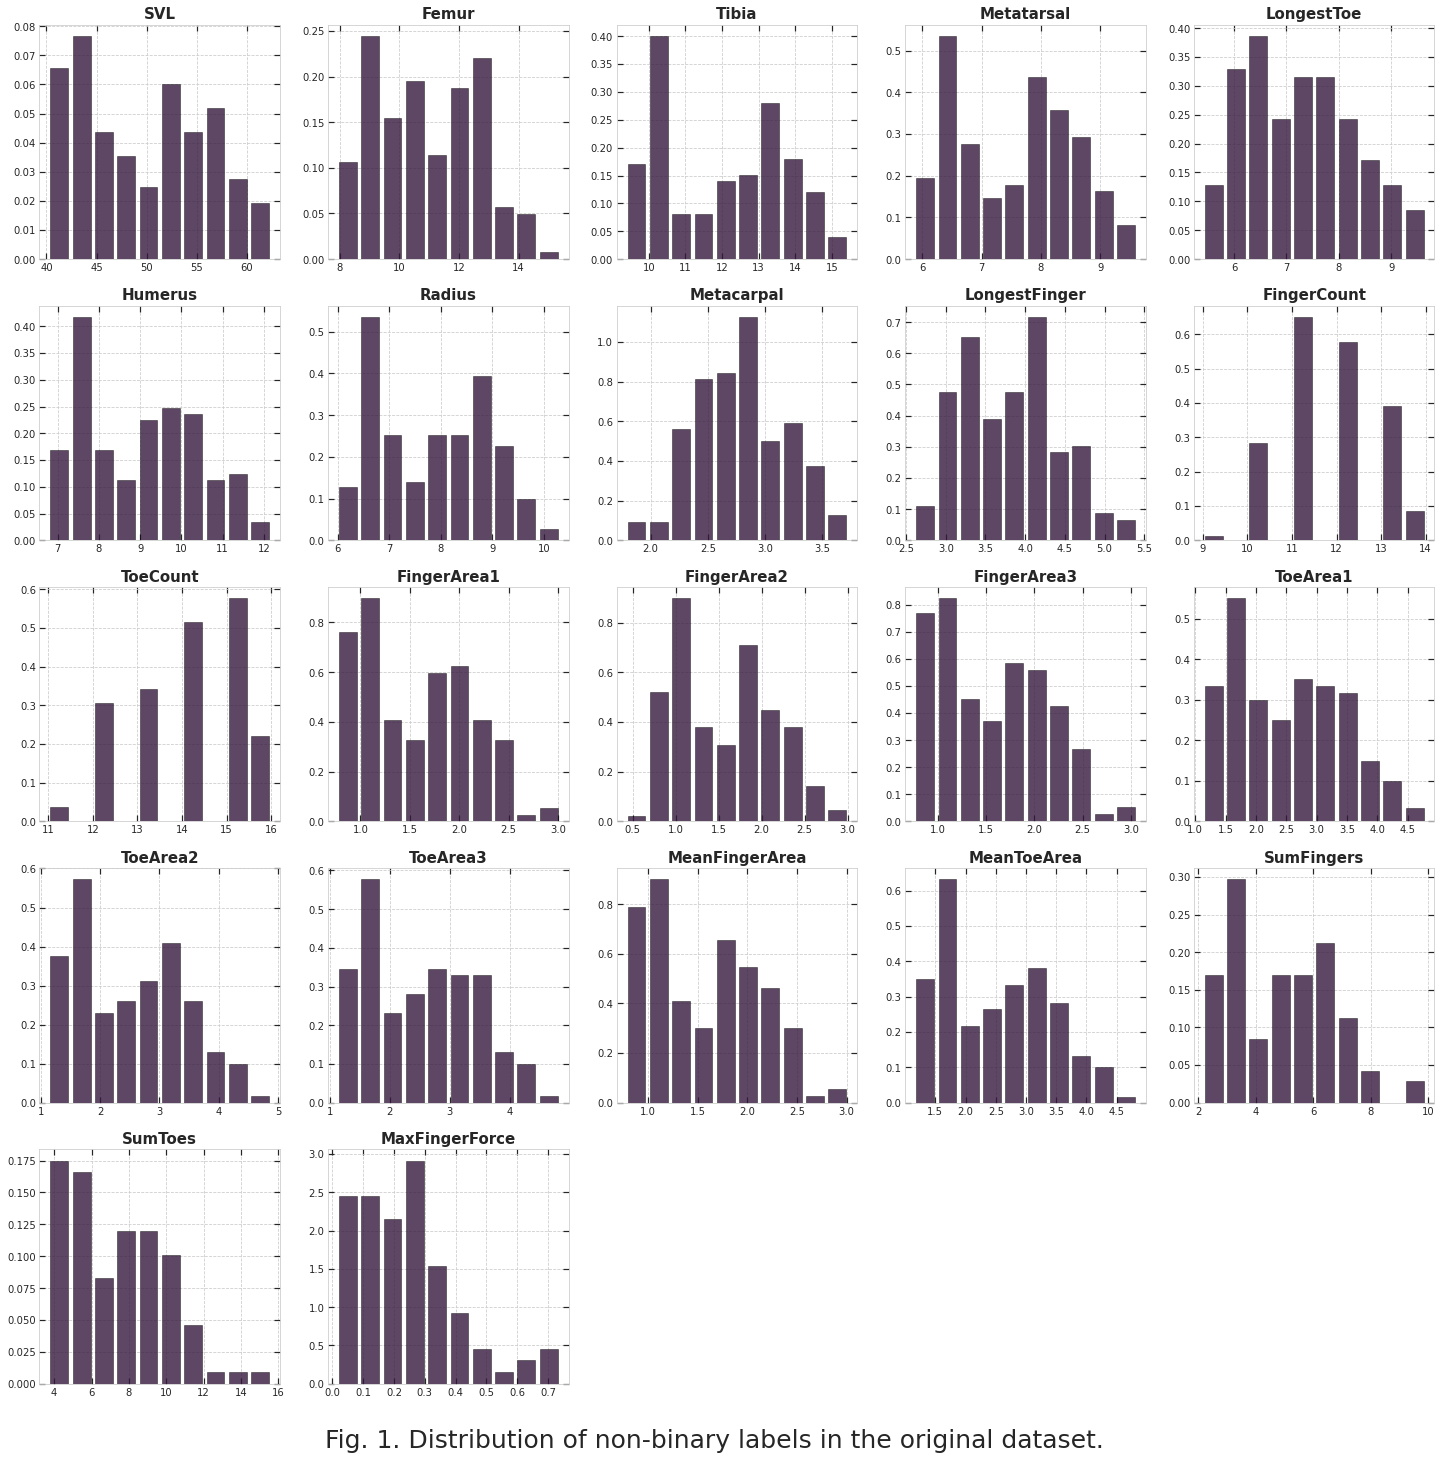

In [62]:
ncols = 5
nrows = (columns[2:].size+ncols-1)//ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*5))

for i, ax in enumerate(axes.reshape(-1)):
    
    if i < columns[2:].size:
        col = columns[2:][i]
        ax.bar(center[col], hist[col], width=width[col],
               alpha=0.8,
               ec='black', lw=0.5, align='center')
        ax.set_title(col, fontsize=axistitlesize-5, fontweight='bold')
        ax.set_ylabel('')

    else : ax.axis('off')
        
plt.suptitle('Fig. 1. Distribution of non-binary labels in the original dataset.',
             fontsize=axistitlesize+5, y=0.1)
plt.show()

In [78]:
# Create a mask to analyze missing entries easier
nan_mask = df_n.isna()
nan_count = nan_mask.sum()
print('Count of missing values:\n' +
      '========================')
print(tabulate([[c, nan_count[c]] for c in nan_count.index], headers=['Feature', 'Count of NaNs']))

Count of missing values:
Feature           Count of NaNs
--------------  ---------------
ID                            0
Hurricane                     0
Origin                        0
Sex                           0
SVL                           0
Femur                         0
Tibia                         0
Metatarsal                    0
LongestToe                    0
Humerus                       0
Radius                        0
Metacarpal                    0
LongestFinger                 0
FingerCount                   1
ToeCount                      1
FingerArea1                   1
FingerArea2                   1
FingerArea3                   1
ToeArea1                      1
ToeArea2                      1
ToeArea3                      1
MeanFingerArea                1
MeanToeArea                   1
SumFingers                   73
SumToes                      73
MaxFingerForce               74


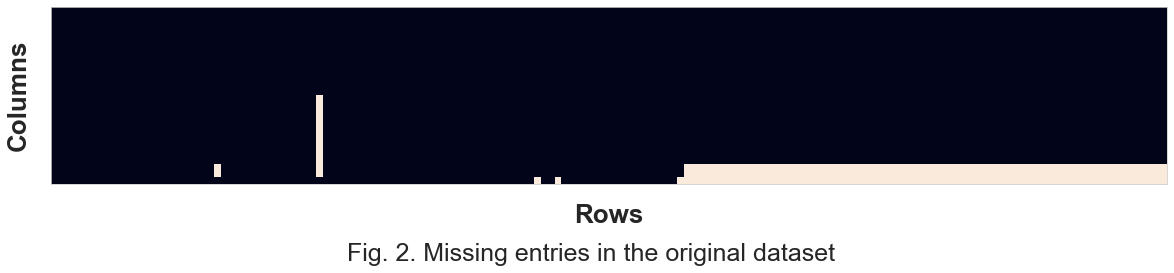

In [79]:
fig, axes = plt.subplots(figsize=(20,20))
axes.set_aspect('equal')

axes.imshow(np.array(df_n.isna()).T)

# Remove XY ticks for now
axes.set_xticks([])
axes.set_yticks([])

# Lapelpad needed because of the removed ticks
lp = 20
axes.set_xlabel('Rows', fontsize=axislabelsize, fontweight='bold', labelpad=lp)
axes.set_ylabel('Columns', fontsize=axislabelsize, fontweight='bold', labelpad=lp)

plt.suptitle('Fig. 2. Missing entries in the original dataset',
             fontsize=axistitlesize+5, y=0.4)

plt.show()

### 1./c. Actually handling missing values

The columns from `FingerCount` to `MeanToeArea` misses only one value in each column. The image above shows, that these values are all missing from the same row, thus we might want to consider removing it from the dataset. The real problem is caused by the columns `SumFingers`, `SumToes` and `MaxFingerForce`, which is referred to as "you can screw up the whole assignment here trollolo" in the task description.

We're basically studying here that what characteristics do reptile types have, which get through a hurricane. These reptiles will be obviously the stronger/more viable types, which can grip onto something for a longer time and with more force and stability to stand against the winds in the hurricane. Also probably much smaller lizards with less grip force will have higher survival rate too, since they can hide easier than bigger and stronger animals. We'll see...

But at the end of the day, the `SumFingers`, `SumToes` and `MaxFingerForce` features will have big impact on the model and we have to keep then at any cost and handle them with extra attention.

## 2. T-SNE
 - embed the data points into a 2D space via T-SNE (preprocess the data if needed). For embedding, use only the numerical features (So do not use Sex, Hurricane and Origin features)
 - what is common in the clusters that we got? visualize the embedded points by using different colour for the different fetautre values (eg on a plot show the female gekkos with red and the male ones with blue). Explore at least 4 features! Do we get separation by the Hurricane variable?

## 3. Linear model + fine-tune
 - train and generate predictions with a logistic regression model using 5 fold cross validation
 - fine-tune the regularization strength for L2 regularization type!
 - show the ROC curve with the AUC value for the best model that you have found

## 4. SVM + fine-tune
 - train and generate predictions with an SVM model using 5 fold cross validation
 - fine-tune the kernel parameters for 2 selected kernels
 - show the ROC curve with the AUC value for the best model that you have found

## 5. RF + feature importances
 - train and generate predictions with a random forest classifier model using leave 5 fold cross validation
 - show the ROC curve with the AUC value for the best model that you have found
 - train a random forest model on all the data and show the 5 most important features based on feature importances of the model

### Hints:
 - On total you can get 10 points for fully completing all tasks.
 - Decorate your notebook with, questions, explanation etc, make it self contained and understandable!
 - Comments you code when necessary
 - Write functions for repetitive tasks!
 - Use the pandas package for data loading and handling
 - Use matplotlib and seaborn for plotting or bokeh and plotly for interactive investigation
 - Use the scikit learn package for almost everything
 - Use for loops only if it is really necessary!
 - Code sharing is not allowed between student! Sharing code will result in zero points.
 - If you use code found on web, it is OK, but, make its source clear! 